In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
import shap

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r"C:\Users\ARYAN KUMAR\Downloads\Fraud.csv")

print("Data Shape:", df.shape)
df.head()

Data Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [4]:
q1 = df['amount'].quantile(0.25)
q3 = df['amount'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
df = df[(df['amount'] >= lower) & (df['amount'] <= upper)]

In [7]:
non_numeric_cols = X_temp.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: Index(['type', 'nameOrig', 'nameDest'], dtype='object')


In [8]:
from sklearn.preprocessing import LabelEncoder

X_encoded = X_temp.copy()
label_encoders = {}

for col in X_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    label_encoders[col] = le


In [9]:
X_numeric = X_encoded.select_dtypes(include=[np.number])

vif_data = pd.DataFrame()
vif_data["feature"] = X_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
print(vif_data)


          feature          VIF
0            step     3.030788
1            type     5.572330
2          amount     2.601062
3        nameOrig     3.062583
4   oldbalanceOrg  1790.190521
5  newbalanceOrig  1818.207996
6        nameDest     4.405743
7  oldbalanceDest   231.691702
8  newbalanceDest   235.013586
9  isFlaggedFraud     1.000007


In [12]:
df = df.drop(['nameOrig', 'nameDest'], axis=1)
df = pd.get_dummies(df, columns=['type'], drop_first=True)
X = df.drop('isFraud', axis=1)
y = df['isFraud']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)


In [15]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [16]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

[[1200675    3362]
 [    788 1203249]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1204037
           1       1.00      1.00      1.00   1204037

    accuracy                           1.00   2408074
   macro avg       1.00      1.00      1.00   2408074
weighted avg       1.00      1.00      1.00   2408074

ROC-AUC Score: 0.9999417497850748


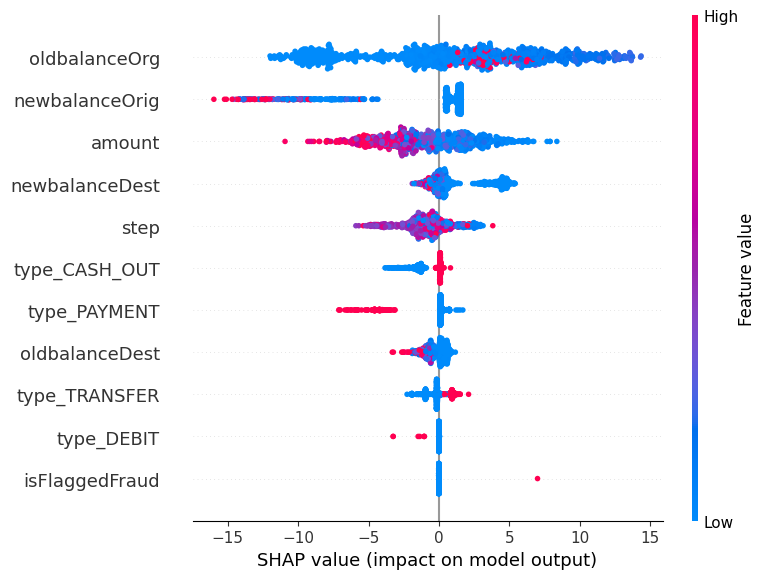

In [17]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train[:1000])
shap.summary_plot(shap_values, features=X_train[:1000], feature_names=X.columns)


In [18]:
import joblib
joblib.dump(model, 'fraud_model.pkl')


['fraud_model.pkl']